First, we load up some useful libraries for visualization and data structures.

In [30]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random
#from heapq import heappush, heappop
try:
    import Queue as Q  # ver. < 3.0
except ImportError:
    import queue as Q
import numpy
import functools

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

(1, 0)


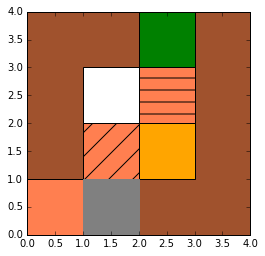

In [51]:
@functools.total_ordering
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        self.path = [] # Paths to get to this state
        self.cost = 0
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if self.grid[y][x] == 'X':
            return True
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric()
        )
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        #assert self.is_free(newx,newy)
        if not self.is_free(newx, newy):
            return False
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    
    
    def available_moves_from_point(self, point):
        if not self.player_alive:
            return []
        (x,y) = point
        #can_switch = self.grid[y][x].isnumeric()
        #return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] #+ (
        valid_set = [(-1,0),(1,0),(0,-1),(0,1)]
        ret_val = []
        for (dx,dy) in valid_set:
            if self.is_free(x+dx, y+dy):
                ret_val.append((dx,dy))
        return ret_val
        #    ["switch"] if can_switch else []
        #)
  
    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def _is_valid_operand(self, other):
        return (hasattr(other, "grid") and hasattr(other, "player_pos") and hasattr(other, "player_alive"))
    
    def __eq__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return ((self.grid, self.player_pos, self.player_alive) ==
                (other.grid, other.player_pos, other.player_alive))
    
    def __lt__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return ((self.grid, self.player_pos, self.player_alive) <
                (other.grid, other.player_pos, other.player_alive))
    def draw_path(self, path):
        for (x, y) in path:
            self.grid[y][x] = "g"
            
   # def __lt__(self, other):
   #     if self==other: return False
   #     return id(self) < id(other)
        
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos


    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)

sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])

print(sample.player_pos)
#sample.move_player(0,1)
#print(sample.available_moves())
#sample.toggle()

sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

In [52]:
def manhattan_distance(point_a, point_b):
    (x0,y0) = point_a
    (x1,y1) = point_b
    return abs(y1-y0) + abs(x1-x0)    

def element_wise_tuple_addition(x, y):
    z = []
    for i in range(len(x)):
        z.append(x[i] + y[i])
    return tuple(z)


def heuristic(maze):
    frontier = Q.PriorityQueue()
    
    frontier.put((0, maze))
    #came_from = {}
    #cost_so_far = {}
    
    #came_from[start] = None
    #cost_so_far[start] = 0
    visited = set([maze])
    
    while not frontier.empty():
        (priority, current) = frontier.get() # Maze
        
        #print(current)
        
        #print(current.available_moves())
        if current.is_at_exit():
            print("Returning path because at " + str(current.player_pos) + " while goal is " + str(current.exit_pos))
            current.path.pop()
            return current.path

        for move in current.available_moves():
            #print("Checking move " + str(move))
            
            successor = current.clone()
            
            if move == "switch":
                #print("Switching at " + str(successor.player_pos))
                successor.toggle()
                
         
                
                #print("Successfully toggled")
            else:
                (x,y) = move
                successor.move_player(x,y)
            
            #if not current in cost_so_far:
                #print("Not found, defaulting to 1")
                #cost_so_far[current] = 1
            
            #new_cost = cost_so_far[current] + 1
            new_cost = current.cost + 1
            
            if not successor in visited or new_cost < current.cost:
                #cost_so_far[current] = new_cost
                priority = new_cost + manhattan_distance(successor.player_pos, successor.exit_pos)
                
                successor.cost += 1
                successor.path.append(successor.player_pos)
                
                frontier.put((priority, successor))
                visited.add(successor)
                #came_from[current] = successor

        
    return []



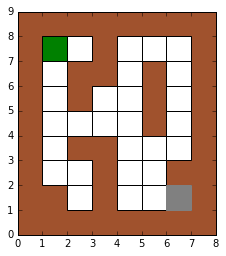

In [53]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

#maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

#mazeUnsolvable1().draw()

Returning path because at (1, 7) while goal is (1, 7)


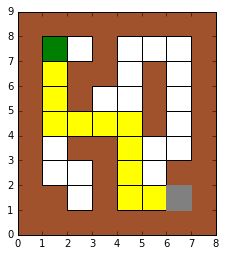

Returning path because at (1, 9) while goal is (1, 9)


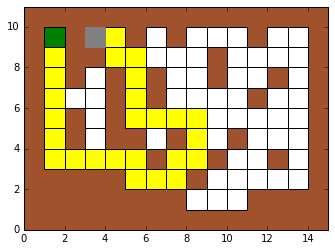

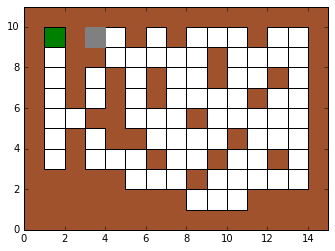

In [54]:
m1 = maze1()
m1.draw_path(heuristic(m1))
m1.draw()

m2 = maze2()
m2.draw_path(heuristic(m2))
m2.draw()

m3 = mazeUnsolvable1()
m3.draw_path(heuristic(m3))
m3.draw()

You also have to be able to handle switch and door puzzles:

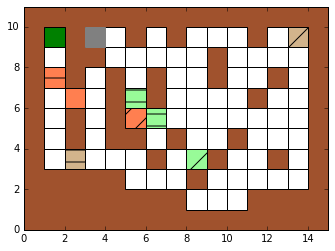

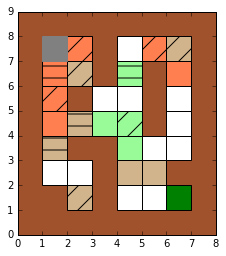

In [38]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

Returning path because at (1, 9) while goal is (1, 9)


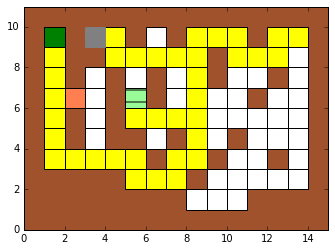

Returning path because at (6, 1) while goal is (6, 1)


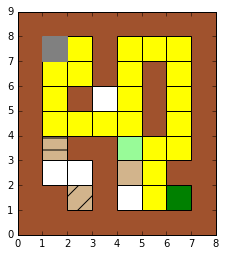

In [55]:
m4 = maze3()
m4.draw_path(heuristic(m4))
m4.draw()

m5 = maze4()
m5.draw_path(heuristic(m5))
m5.draw()





# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [8]:
def mcts(maze,iterations):
    # Return the expected value (a number between 0 for "player dead", 1 for "made it to the end")
    # for a budget of `iterations` rollouts.
    # Should also return the best found path (the one most likely to lead to success).
    # Here, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` rollouts, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([], 0)

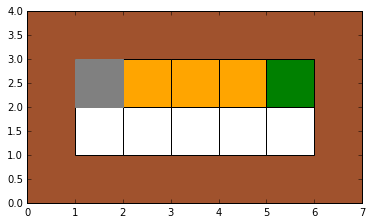

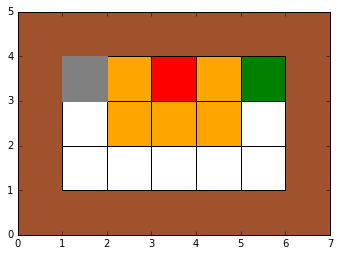

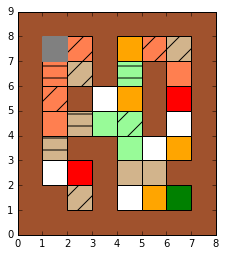

In [9]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [10]:
a = {maze1() : "a"}
print(a)

{<__main__.Maze object at 0x1038200b8>: 'a'}


In [11]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)

# Bonus Assignment

Make an adversary for the maze who is trying to eat the player. Try to get the best performing adversary possible!